In [1]:
DATASET_ROOT = "./dataset"

In [2]:
import datetime
import os
import random

from typing import Tuple, Union

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as nnF
import torchvision.transforms.functional as trF
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode

Before we begin, let's see how the distribution of land price looks like

<Axes: >

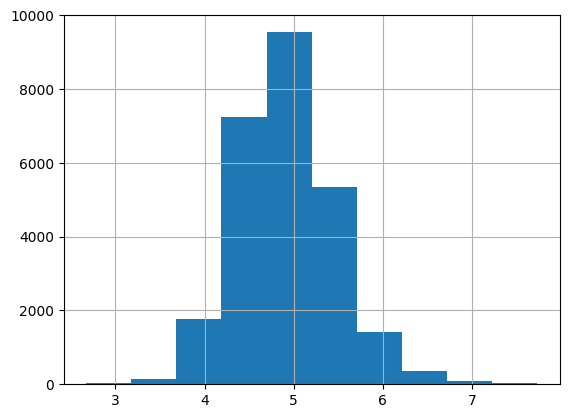

In [3]:
df_all = pd.read_csv(
    os.path.join(DATASET_ROOT, "data_catalogue.csv"),
    index_col=False
)
# df_all["landprice"].hist(bins=10)
df_all["log_landprice"] = np.log10(df_all["landprice"])
df_all["log_landprice"].hist(bins=10)

## [Only once] Split into train, val, test

In [4]:
TRAIN_RATE = 0.8
VAL_RATE = 0.1
TEST_RATE = 0.1
assert( TRAIN_RATE + VAL_RATE + TEST_RATE == 1.0 )

df = pd.read_csv(
    os.path.join(DATASET_ROOT, "data_catalogue.csv"),
    index_col=False
)
data_count = len(df)

shuffled_indices = list(range(data_count))
random.shuffle(shuffled_indices)

train_df = df.iloc[
    shuffled_indices[:int(data_count*TRAIN_RATE)], :
]
val_df = df.iloc[
    shuffled_indices[int(data_count*TRAIN_RATE):int(data_count*(TRAIN_RATE+VAL_RATE))] , :
]
test_df = df.iloc[
    shuffled_indices[int(data_count*(TRAIN_RATE+VAL_RATE)):], :
]

train_df.to_csv(
    os.path.join(DATASET_ROOT,"train_data_catalogue.csv"),
    index=False
)
val_df.to_csv(
    os.path.join(DATASET_ROOT,"val_data_catalogue.csv"),
    index=False
)
test_df.to_csv(
    os.path.join(DATASET_ROOT,"test_data_catalogue.csv"),
    index=False
)

## Define Dataset and DataLoader

In [5]:
class LandPriceDataset(Dataset):
    def __init__(
        self,
        dataset_root_dir_path: str,
        catalogue_csv_name: str,
        target_img_size: Union[Tuple[int, int], None] = None,
    ) -> None:
        super().__init__()
        df = pd.read_csv(
            os.path.join(dataset_root_dir_path, catalogue_csv_name),
            index_col=False
        )
        self.img_paths = [
            os.path.join(dataset_root_dir_path, "images", img_filename)
            for img_filename in df["img_filename"].to_list()
        ]
        self.segmap_paths = [
            os.path.join(dataset_root_dir_path, "masked_images", mask_filename)
            for mask_filename in df["mask_filename"].to_list()
        ]
        self.landprices = df["landprice"].to_list()
        self.target_img_size = target_img_size

    def __len__(self) -> int:
        return len(self.img_paths)

    def __getitem__(self, index: int) -> Tuple[str, Tensor, Tensor, Tensor]:
        img_path = self.img_paths[index]
        image = read_image(
            path=img_path,
            mode=ImageReadMode.RGB
        )
        # extract 000001 from satellite000001.png
        image_id = os.path.basename(img_path)[9:15]

        segmap_path = self.segmap_paths[index]
        segmap = read_image(
            path=segmap_path,
            mode=ImageReadMode.GRAY
        )

        landprice = self.landprices[index]
        landprice = torch.tensor(landprice)

        if self.target_img_size:
            image = trF.resize(
                img=image,
                size=self.target_img_size,
            )
            segmap = nnF.interpolate(
                input=segmap.unsqueeze(0),
                size=self.target_img_size,
                mode="nearest",
            )

        # one-hot encoding for segmap
        SEGMAP_CLASS_NUM = 8
        segmap = nnF.one_hot(segmap.long(), SEGMAP_CLASS_NUM).transpose(1, 4).squeeze()
        # segmap is like torch.Size([SEGMAP_CLASS_NUM, SEGMAP_H, SEGMAP_W])

        return image_id, image.float(), segmap.float(), landprice.float()

In [6]:
TARGET_IMAGE_SIZE = 480

train_ds = LandPriceDataset(
    dataset_root_dir_path=DATASET_ROOT,
    catalogue_csv_name="train_data_catalogue.csv",
    target_img_size=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)
)
val_ds = LandPriceDataset(
    dataset_root_dir_path=DATASET_ROOT,
    catalogue_csv_name="val_data_catalogue.csv",
    target_img_size=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
)
test_ds = LandPriceDataset(
    dataset_root_dir_path=DATASET_ROOT,
    catalogue_csv_name="test_data_catalogue.csv",
    target_img_size=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
)

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Define model

In [8]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

class FeatureMapCompresser(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.3)
        # (height_of_feature_map)x(width_of_feature_map)x(num_filter_for_each_channel)
        self.feat_wise_fc_to_128 = nn.Linear(in_features=29*29*2, out_features=128)
        self.feat_wise_fc_last = nn.Linear(in_features=128, out_features=32)

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.feat_wise_fc_to_128(x)
        x = self.feat_wise_fc_last(x)
        return x

class EfficientNetBasedFeatureExtractor(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        whole_effnet = efficientnet_v2_m(
            weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1
        )
        # omit the last classification layer
        self.effnet_without_classifier = nn.Sequential(
            whole_effnet.features,
            whole_effnet.avgpool,
        )
        self.fc_to_512 = nn.Linear(in_features=1280, out_features=512)
        self.fc_to_256 = nn.Linear(in_features=512, out_features=256)

    def forward(self, x):
        x = self.effnet_without_classifier(x)  # size of x == torch.Size([BATCH, 1280, 1, 1])
        x = torch.squeeze(x)
        x = self.fc_to_512(x)
        x = self.fc_to_256(x)
        return x

class LandNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.effnet_feat_extractor = EfficientNetBasedFeatureExtractor()
        self.conv_feat_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=6, # number of meaningful class in segmentation maps
                out_channels=12,
                kernel_size=4,
                groups=6  # MUST be the same as `in_channels`. This works as depth-wise convolution
                # `out_channels`/`in_channels` (= 2) dedicated filters are applied to each channel in the input
            ),
            nn.MaxPool2d(kernel_size=16),  # each side of feature map becomes 1/16 the length of previous one
            # # this another convolution seems to be unnecessary
            # nn.Conv2d(
            #     in_channels=18,
            #     out_channels=36,
            #     kernel_size=2,
            #     groups=3,
            # ),
            # nn.MaxPool2d(kernel_size=4),
        )
        self.feat_compresser_for_build = FeatureMapCompresser()
        self.feat_compresser_for_road = FeatureMapCompresser()
        self.feat_compresser_for_water = FeatureMapCompresser()
        self.feat_compresser_for_barren = FeatureMapCompresser()
        self.feat_compresser_for_forest = FeatureMapCompresser()
        self.feat_compresser_for_agri = FeatureMapCompresser()

        self.trailing_fc_to_256 = nn.Linear(in_features=256+32*6, out_features=256)
        self.trailing_fc_to_64 = nn.Linear(in_features=256, out_features=64)
        self.last_fc = nn.Linear(in_features=64, out_features=1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, image, segmap):
        feat_image = self.effnet_feat_extractor(image)

        y = self.conv_feat_extractor(segmap)
        feat_build = self.feat_compresser_for_build(y[:, :2, ...])
        feat_road = self.feat_compresser_for_road(y[:, 2:4, ...])
        feat_water = self.feat_compresser_for_water(y[:, 4:6, ...])
        feat_barren = self.feat_compresser_for_barren(y[:, 6:8, ...])
        feat_forest = self.feat_compresser_for_forest(y[:, 8:10, ...])
        feat_agri = self.feat_compresser_for_agri(y[:, 10:12, ...])

        feat_concat = torch.cat(
            tensors=[feat_image, feat_build, feat_road, feat_water, feat_barren, feat_forest, feat_agri],
            dim=1
        )
        overall_feat = self.trailing_fc_to_256(feat_concat)
        overall_feat = self.dropout(overall_feat)
        overall_feat = self.trailing_fc_to_64(overall_feat)
        pred_value = self.last_fc(overall_feat)

        return pred_value

Check the number of parameters

In [9]:
landnet = LandNet().to(device)
params = 0
for p in landnet.parameters():
    if p.requires_grad:
        params += p.numel()
print("number of parameters: ", params)

number of parameters:  55094529


Test if the shape is correct

In [10]:
# dummy_image = torch.randn(2, 3, 480, 480)
# dummy_segmap = torch.randn(2, 6, 480, 480)
# landnet(dummy_image, dummy_segmap)

# # features only: torch.Size([2, 1280, 15, 15])
# # features+avgpool: torch.Size([2, 1280, 1, 1])

## Define Training loop

In [11]:
from textwrap import dedent
from torch.utils.tensorboard import SummaryWriter

# Based on the observation at the beginning of this notebook,
# let's employ Rooted Mean Squared Logarithmic Error
# https://atmarkit.itmedia.co.jp/ait/articles/2106/02/news021.html
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.constant = 10

    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + self.constant), torch.log(actual + self.constant)))

loss_func = RMSLELoss()
optimizer = torch.optim.AdamW(
    params=landnet.parameters(),
    weight_decay=1e-4
)

def train(
    dataloader: DataLoader,
    model: LandNet,
    loss_func: RMSLELoss,
    optimizer: torch.optim.AdamW,
    current_epoch: int,
    writer: SummaryWriter,
):
    whole_size = len(dataloader.dataset)
    model.train()
    mean_loss_in_epoch = .0
    mean_deviation_in_epoch = .0
    for batch_pos, (image_id, image, segmap, landprice) in enumerate(dataloader):

        image, landprice = image.to(device), landprice.to(device)
        # omit segmaps for Ignore (0), Background (1)
        segmap = segmap[:, 2:, ...]
        segmap = segmap.to(device)

        # compute the prediction
        pred = model(image, segmap)
        loss = loss_func(pred, landprice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # update mean loss
        loss = loss.item()
        mean_loss_in_epoch = (batch_pos*mean_loss_in_epoch + loss)/(batch_pos+1)
        # update mean deviation rate
        deviations = torch.abs(pred - landprice) / landprice
        mean_deviation_in_batch = deviations.mean().item()
        mean_deviation_in_epoch = (batch_pos*mean_deviation_in_epoch + mean_deviation_in_batch)/(batch_pos+1)

        if batch_pos % 100 == 0:
            current_pos = batch_pos*len(image)
            print(dedent(
                f"""[{current_pos:>5d}/{whole_size:>5d}]\n\
                loss: {loss:>7f}\n\
                current_mean_loss_in_epoch: {mean_loss_in_epoch:>7f}\n\
                current_mean_deviation_rate_in_epoch: {mean_deviation_in_epoch:>7f}"""))

    writer.add_scalar(
        tag="loss/train",
        scalar_value=mean_loss_in_epoch,
        global_step=current_epoch,
    )
    writer.add_scalar(
        tag="deviation_rate/train",
        scalar_value=mean_deviation_in_epoch,
        global_step=current_epoch,
    )
    writer.flush()

def validate(
    dataloader: DataLoader,
    model: LandNet,
    loss_func: RMSLELoss,
    current_epoch: int,
    writer: Union[SummaryWriter, None] = None,
    summary_csv_path: Union[str, None] = None,
):
    whole_size = len(dataloader.dataset)
    model.eval()
    mean_loss_in_epoch = .0
    mean_deviation_in_epoch = .0
    image_id_log = []
    deviation_log = []
    pred_log = []
    landprice_log = []
    with torch.no_grad():
        for batch_pos, (image_id, image, segmap, landprice) in enumerate(dataloader):

            image, landprice = image.to(device), landprice.to(device)
            segmap = segmap[:, 2:, ...]
            segmap = segmap.to(device)

            # compute the prediction
            pred = model(image, segmap)
            loss = loss_func(pred, landprice)

            # update mean loss
            loss = loss.item()
            mean_loss_in_epoch = (batch_pos*mean_loss_in_epoch + loss)/(batch_pos+1)
            # update mean deviation rate
            deviations = torch.abs(pred.squeeze() - landprice) / landprice
            mean_deviation_in_batch = deviations.mean().item()
            mean_deviation_in_epoch = (batch_pos*mean_deviation_in_epoch + mean_deviation_in_batch)/(batch_pos+1)

            if summary_csv_path:
                image_id_log += image_id
                pred_log += pred.squeeze().cpu().tolist()
                landprice_log += landprice.cpu().tolist()
                deviation_log += deviations.cpu().tolist()

            if batch_pos % 100 == 0:
                current_pos = batch_pos*len(image)
                print(dedent(
                    f"[{current_pos:>5d}/{whole_size:>5d}]\n\
                    loss: {loss:>7f}\n\
                    current_mean_loss_in_epoch: {mean_loss_in_epoch:>7f}\n\
                    current_mean_deviation_rate_in_epoch: {mean_deviation_in_epoch:>7f}"))

    if summary_csv_path:
        df = pd.DataFrame(
            data={
                "image_id": image_id_log,
                "prediction": pred_log,
                "true_landprice": landprice_log,
                "deviation": deviation_log,
            }
        )
        df.to_csv(summary_csv_path, index=False)

    if writer:
        writer.add_scalar(
            tag="loss/val",
            scalar_value=mean_loss_in_epoch,
            global_step=current_epoch,
        )
        writer.add_scalar(
            tag="deviation_rate/val",
            scalar_value=mean_deviation_in_epoch,
            global_step=current_epoch,
        )
        writer.flush()

2023-07-17 21:32:28.511211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create dataloader

In [12]:
BATCH_SIZE = 5
train_dl = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(dataset=val_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE)

## Execute training!

In [13]:
epochs = 3

writer = SummaryWriter()
datetime_str = str(datetime.datetime.now()).replace(" ", "_")
os.makedirs(
    name=f"checkpoints/{datetime_str}",
    exist_ok=True,
)
for epoch in range(epochs):
    print(f"Epoch {epoch}\n---------------------------------------")
    train(
        dataloader=train_dl,
        model=landnet,
        loss_func=loss_func,
        optimizer=optimizer,
        current_epoch=epoch,
        writer=writer,
    )
    summary_csv_path = os.path.join("checkpoints", datetime_str, f"landnet_val_epoch{epoch}.csv")
    validate(
        dataloader=val_dl,
        model=landnet,
        loss_func=loss_func,
        current_epoch=epoch,
        writer=writer,
        summary_csv_path=summary_csv_path
    )
    torch.save(
        obj=landnet.state_dict(),
        f=os.path.join("checkpoints", datetime_str, f"landnet_checkpoint_epoch{epoch}.pth")
    )

writer.close()

Epoch 0
---------------------------------------


/home/toda/.venv/ml/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/toda/.venv/ml/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

[    0/20794]
                loss: 9.791926
                current_mean_loss_in_epoch: 9.791926
                current_mean_deviation_rate_in_epoch: 1.000001
[  500/20794]
                loss: 1.405784
                current_mean_loss_in_epoch: 1.985874
                current_mean_deviation_rate_in_epoch: 1.724654
[ 1000/20794]
                loss: 1.199694
                current_mean_loss_in_epoch: 1.663408
                current_mean_deviation_rate_in_epoch: 1.829442
[ 1500/20794]
                loss: 0.931054
                current_mean_loss_in_epoch: 1.496973
                current_mean_deviation_rate_in_epoch: 1.715058
[ 2000/20794]
                loss: 0.422878
                current_mean_loss_in_epoch: 1.405441
                current_mean_deviation_rate_in_epoch: 1.675864
[ 2500/20794]
                loss: 1.757351
                current_mean_loss_in_epoch: 1.373535
                current_mean_deviation_rate_in_epoch: 1.720861
[ 3000/20794]
                loss

/home/toda/.venv/ml/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[    0/ 2599]
                    loss: 1.136313
                    current_mean_loss_in_epoch: 1.136313
                    current_mean_deviation_rate_in_epoch: 1.048621
[  500/ 2599]
                    loss: 1.332837
                    current_mean_loss_in_epoch: 1.149489
                    current_mean_deviation_rate_in_epoch: 1.516117
[ 1000/ 2599]
                    loss: 0.649741
                    current_mean_loss_in_epoch: 1.153048
                    current_mean_deviation_rate_in_epoch: 1.496893
[ 1500/ 2599]
                    loss: 0.991934
                    current_mean_loss_in_epoch: 1.163238
                    current_mean_deviation_rate_in_epoch: 1.587317
[ 2000/ 2599]
                    loss: 0.774244
                    current_mean_loss_in_epoch: 1.157710
                    current_mean_deviation_rate_in_epoch: 1.613466
[ 2500/ 2599]
                    loss: 1.115322
                    current_mean_loss_in_epoch: 1.157369
                    current_m

## Test

In [14]:
validate(
    dataloader=test_dl,
    model=landnet,
    loss_func=loss_func,
    current_epoch=0,
    summary_csv_path=os.path.join("checkpoints", datetime_str, "landnet_test.csv"),
)

[    0/ 2600]
                    loss: 0.977846
                    current_mean_loss_in_epoch: 0.977846
                    current_mean_deviation_rate_in_epoch: 1.105529
[  500/ 2600]
                    loss: 1.444187
                    current_mean_loss_in_epoch: 1.231535
                    current_mean_deviation_rate_in_epoch: 1.695905
[ 1000/ 2600]
                    loss: 1.411825
                    current_mean_loss_in_epoch: 1.189711
                    current_mean_deviation_rate_in_epoch: 1.513361
[ 1500/ 2600]
                    loss: 1.721498
                    current_mean_loss_in_epoch: 1.213530
                    current_mean_deviation_rate_in_epoch: 1.575023
[ 2000/ 2600]
                    loss: 1.143088
                    current_mean_loss_in_epoch: 1.202851
                    current_mean_deviation_rate_in_epoch: 1.518699
[ 2500/ 2600]
                    loss: 0.975257
                    current_mean_loss_in_epoch: 1.215291
                    current_m